KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student names: <span style="color:red"> Antonios Glioumpas, Panagiotis Langaris, Aristotelis Styanidis, Emmanouil Gkigkilinis, Amke Steukers </span>.

The goal of this assignment was to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features.
---------------------------------------------------------------
This notebook is structured as follows:

0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

This notebook is written as a tutorial for students who need to get a first hands-on introduction to the techniques that we applied. --------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

from sklearn import decomposition
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import seaborn as sns

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '../input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '../input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('../input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('../input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [4]:
# The test set only contains an identifier and corresponding image information.
test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

The HAAR face detector preprocess() function was modified because there were cases where the first detected image did not belong to the class that it was supposed to belong.

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


**Important Note:**

Keep in mind that the HAAR face detector works stochastically so there is a chance detecting different faces in different program executions. In order to work with the correct preprocessed cropped face dataset, you have to run the stored preprocessed data located in the folder '/prepped-data'.

In [6]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess_train(self, data_row, index):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        
        # We closely inspected all the faces detected in each image and 
        # changed the ones that did not belong to the class that they were supposed to belong
        # It is worth mentioning that there might be a chance of detecting the faces in different order
        # so you have to visualize and check that the plotted faces are the correct ones
        
        if index == 5 or index == 23 or index == 24 or index == 32 or index == 49 or index == 50 or index == 60 or index == 77: 
            return cv2.resize(faces[1], self.face_size, interpolation = cv2.INTER_AREA)
        elif index == 28:
            return cv2.resize(faces[4], self.face_size, interpolation = cv2.INTER_AREA)
        elif index == 70:
            return cv2.resize(faces[2], self.face_size, interpolation = cv2.INTER_AREA)
        elif index == 40:
            # We decided not to keep the blurred face image cause it was just adding noise to our calculations
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        else: 
            return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
     
                 
    def preprocess_test(self, data_row):
        faces = self.extract_faces(data_row['img'])
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)

    
    def __call__(self, data , arg):
    # arg==0->preprocess train    
        if arg==0:
            return np.stack([self.preprocess_train(row, index) for index, row in data.iterrows()]).astype(int)
    # arg==1->preprocess test
        if arg==1:
            return np.stack([self.preprocess_test(row) for _, row in data.iterrows()]).astype(int)

**Visualise:**

Let's plot a few examples.

In [7]:
def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

In [8]:
# parameter to play with 
FACE_SIZE = (100, 100)

# preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train, arg = 0), train['class'].values
test_X = preprocessor(test, arg = 1)

In [9]:
# Extra preprocessing step to get rid of the NAN images from the training set and their corresponding labels

def extra_preprocess(data, labels):
    temp = []
    temp_label = []
    
    for i in range(len(data)):
        if np.unique((data[i]))[0] >= 0:
            temp.append(data[i])
            temp_label.append(labels[i])

    temp = np.array(temp)
    temp_label = np.array(temp_label)
    
    return temp, temp_label

train_X, train_y = extra_preprocess(train_X, train_y)

The following blocks can be used in order to visualize the current cropped faces extracted by the HAAR Preprocessor. Most probably wrong parts of the image might have been detected as faces.

In [10]:
# preprocessed images 
# plot faces of Michael and Sarah
# plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

In [11]:
# preprocessed images
# plot faces of Jesse
# plot_image_sequence(train_X[train_y == 1], n=28, imgs_per_row=10)

In [12]:
# preprocessed images
# plot faces of Mila
# plot_image_sequence(train_X[train_y == 2], n=28, imgs_per_row=10)

## Warning:

Each plotted image sequence should contain faces of only one class. In case you see a face that shouldn't be contained in that class please restart the kernel and run the code from scratch. The distribution of faces in the preprocessed dataset should be Michael & Sarah (10 images), Jesse (28 images) and Mila (28 images).

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

**Important Note:**

We stored the preprocessed data locally so that we do not have to run this part of code repeatedly. Feel free to do the same.

In [13]:
# save preprocessed data to the kaggle path
#prep_path = '../input/prepped-data'
#if not os.path.exists(prep_path):
#    os.mkdir(prep_path)
    
#np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
#np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
#np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data from the corresponding kaggle path
prep_path = '../input/prepped-data'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

In [14]:
# The cropped faces are reordered in the following way: 
# Michael (10 images), Sarah (10 images), Jesse (28 images), Mila (28 images)
# Total preprocessed images: 76
michael = []
sarah = []
for i in range(len(train_X[train_y == 0])):
    if (i==0 or i==1 or i==3 or i==4 or i==6 or i==9 or i==11 or i==17 or i==18 or i==19):
        michael.append(train_X[train_y == 0][i])
    else:
        sarah.append(train_X[train_y == 0][i])
michael = np.array(michael)
sarah = np.array(sarah)
jesse = train_X[train_y == 1]
mila = train_X[train_y == 2]

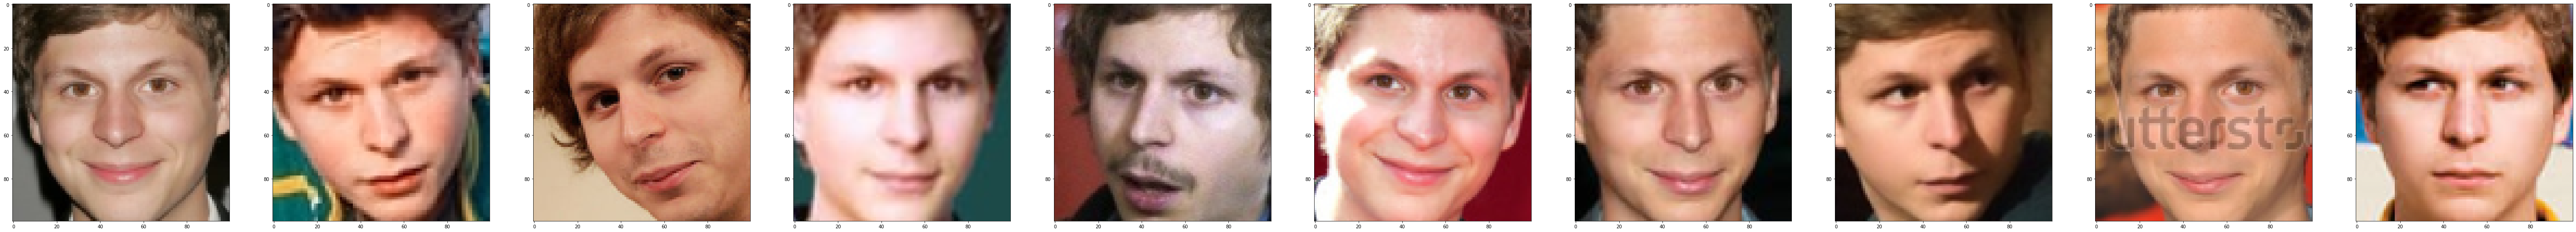

In [15]:
plot_image_sequence(michael, n=10, imgs_per_row=10)

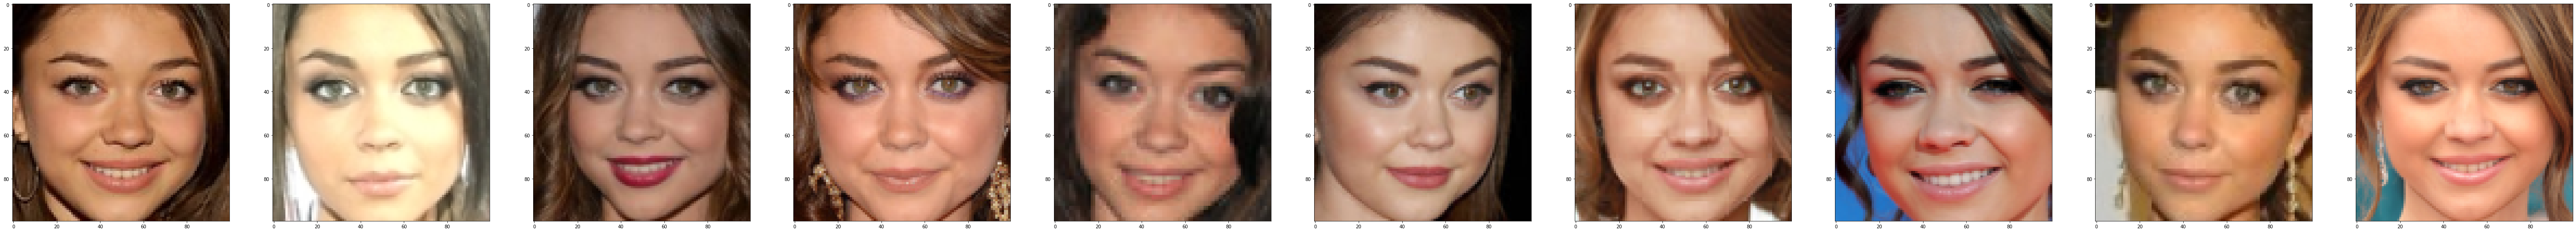

In [16]:
plot_image_sequence(sarah, n=10, imgs_per_row=10)

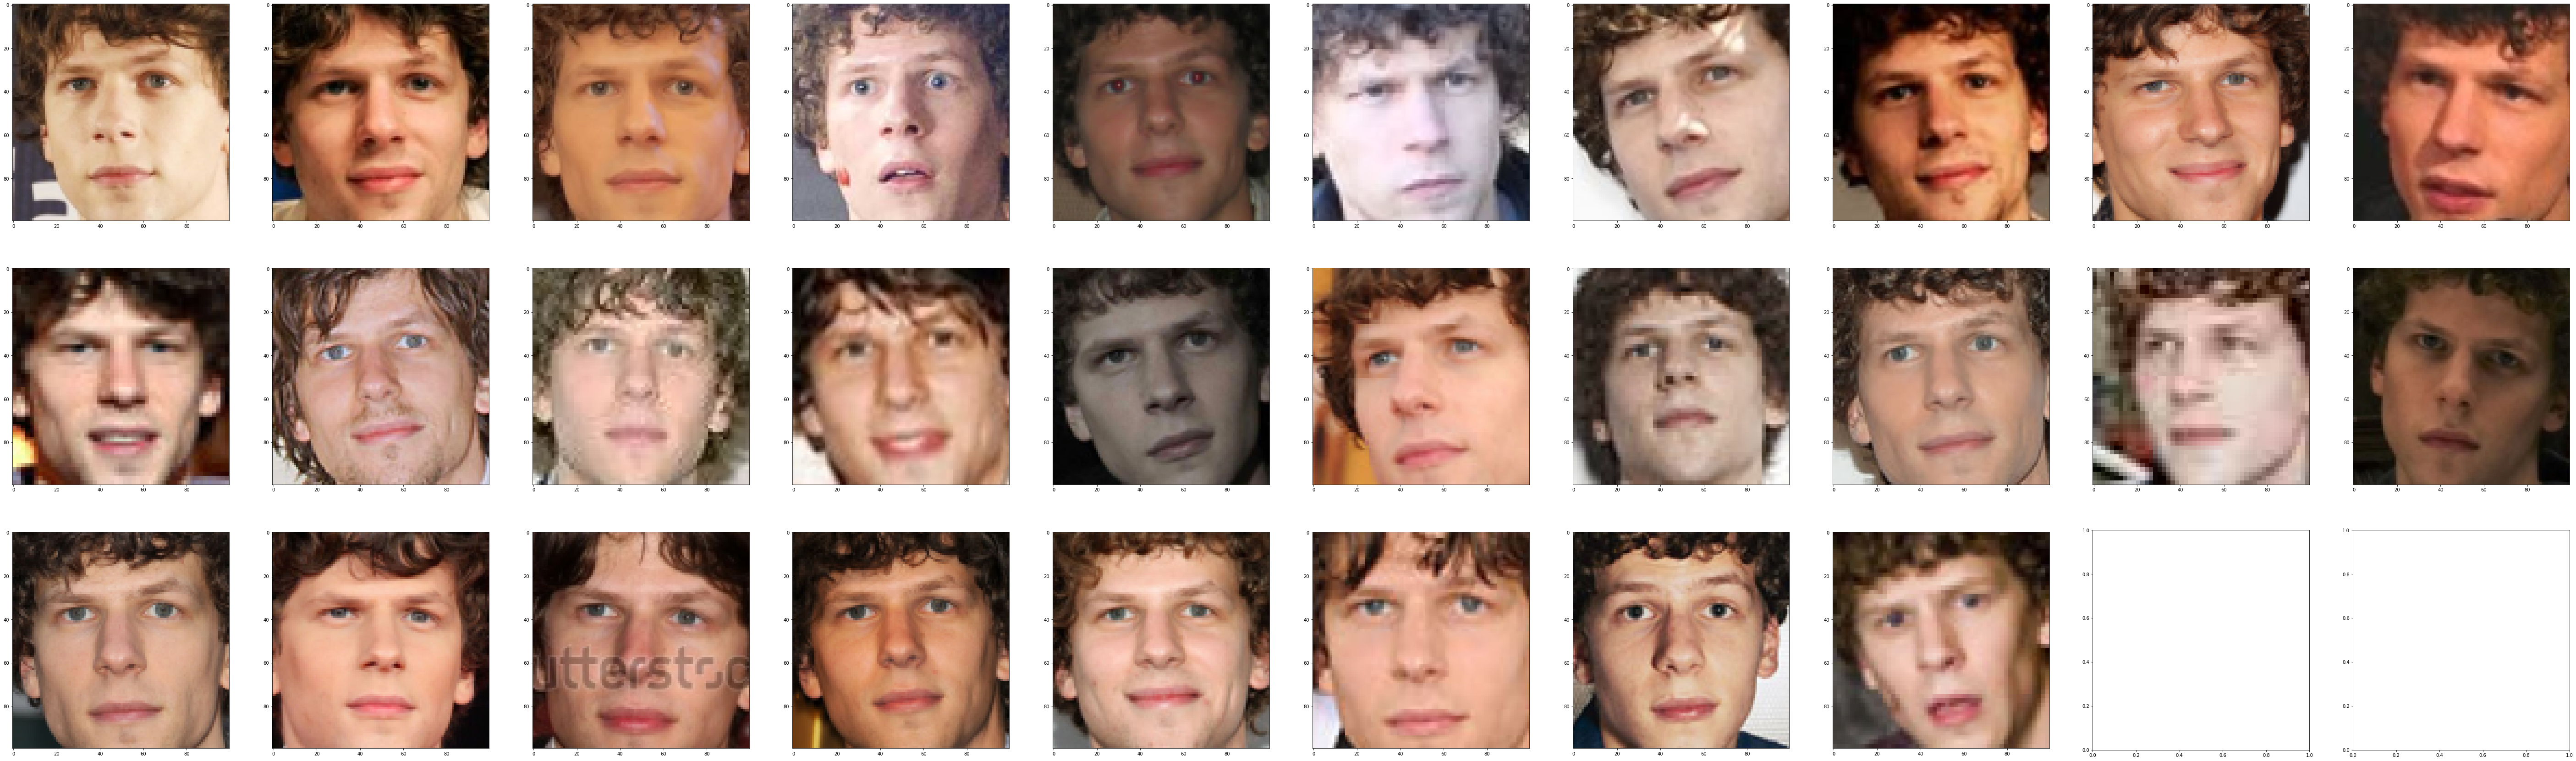

In [17]:
plot_image_sequence(jesse, n=28, imgs_per_row=10)

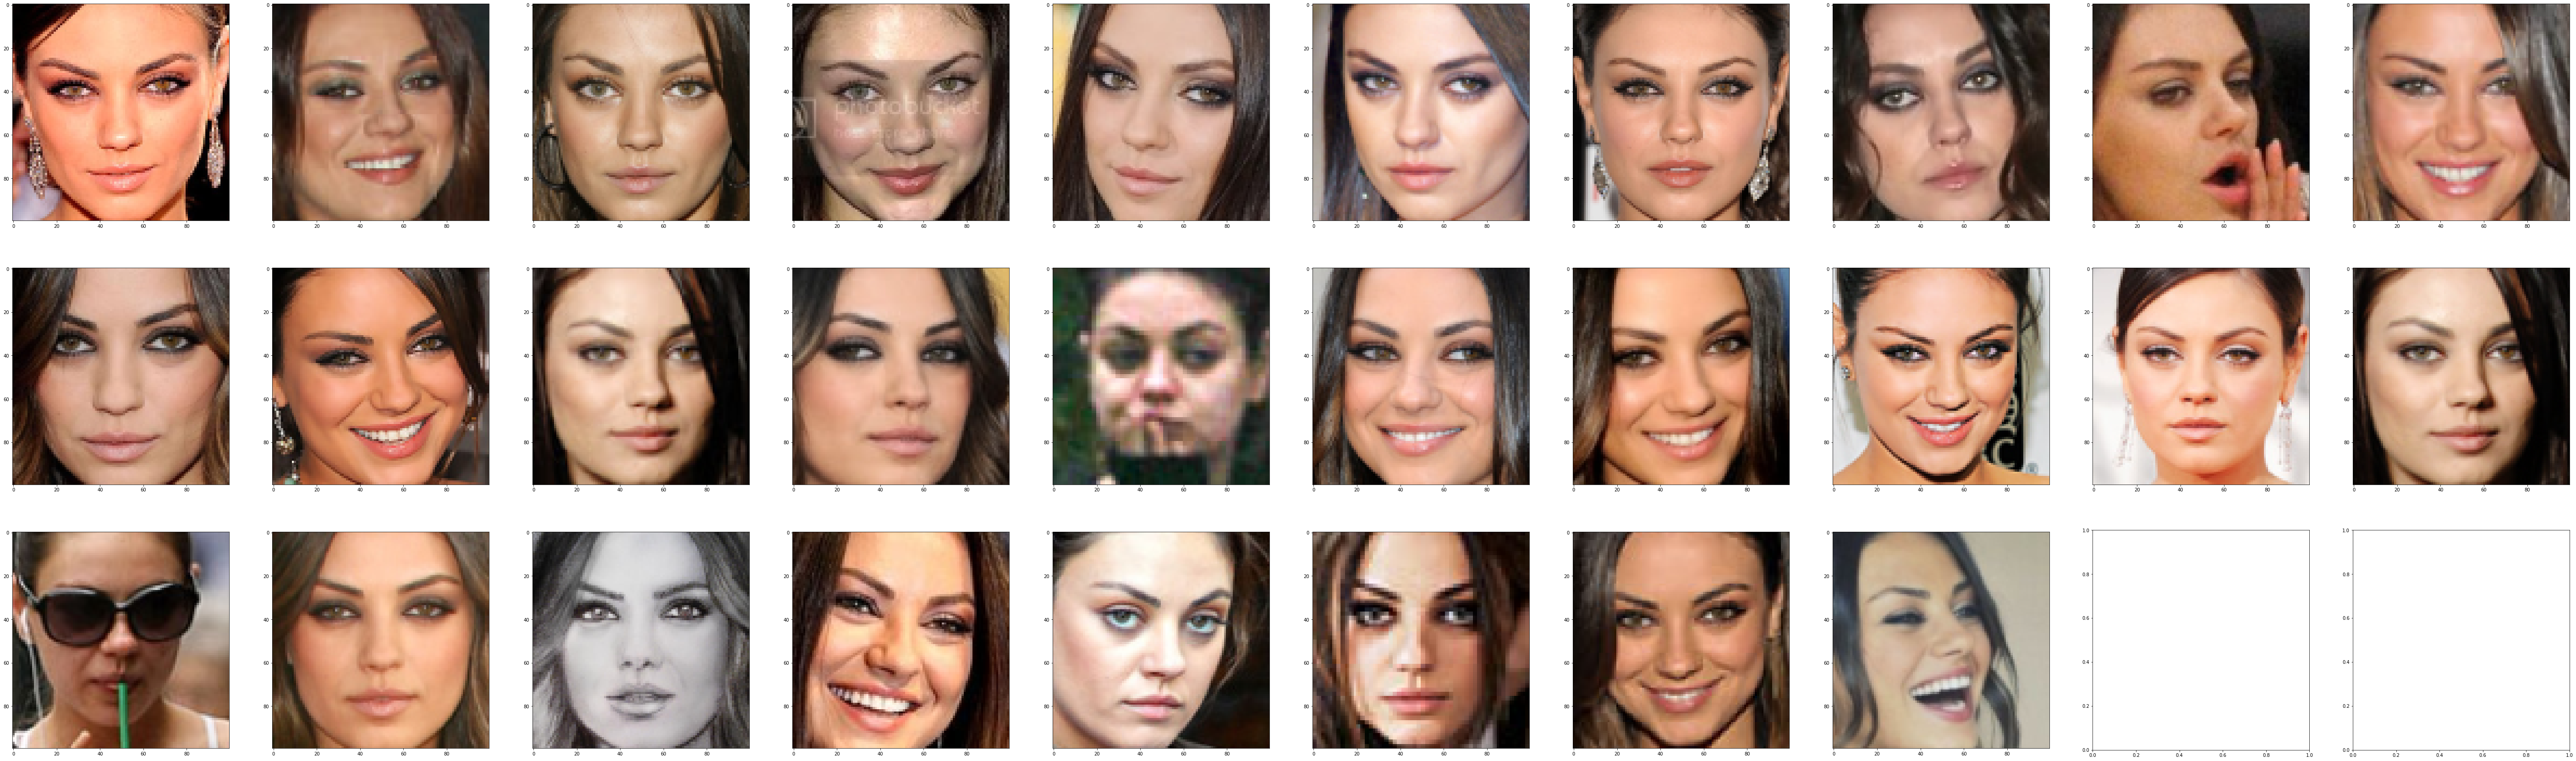

In [18]:
plot_image_sequence(mila, n=28, imgs_per_row=10)

In [19]:
# All faces from different classes merged into one training set 
# as well as their corresponding labels in one array respectively

train_X = np.concatenate((michael, sarah, jesse, mila), axis=0)
train_y = np.concatenate((np.ones(20)*(0), np.ones(28), np.ones(28)*2), axis=0)

In [20]:
print("Dimensions of training set: \t", train_X.shape)
print("Dimensions of training classes:\t", train_y.shape)

Dimensions of training set: 	 (76, 100, 100, 3)
Dimensions of training classes:	 (76,)


## Data Augmentation

In [21]:
# Data Augmentation
# Using gaussian blur, mirroring and sharpenning augmentation techniques

import scipy
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

class data_augm():

    def __init__(self,img,method):
        self.img = img
        if (method == 'Blur'): train = self.gaussian_noise(self.img)
        elif (method == 'Mirror'): train = self.flip_y(self.img)
        elif (method == 'Sharpen'): train = self.sharpen(self.img)
        self.train = train

    def getAugData(self):
        # return constructed augmented dataset
        return self.train


    def gaussian_noise(self, images, mean=0, sigma=1):
        train = [] 
        for sigma in np.arange(1 , 2 , 0.5):
            for img in images:
                img = gaussian_filter(img, sigma)
                train.append(img)

        return np.array(train)

    
    
    def flip_y(self , images):
        train = [] 
        for img in images:
            train.append(np.fliplr(img))

        return np.array(train)
    
    
    def sharpen(self , images):
        train = [] 
        for img in images:
            blurred_f = ndimage.gaussian_filter(img, 3)
            filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
            alpha = 15
            sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
            train.append(sharpened)
        
        return np.array(train)
      

train_X_mirror = data_augm(train_X, method = 'Mirror').getAugData()
train_X_blurred = data_augm(train_X, method = 'Blur').getAugData()
train_X_sharpen = data_augm(train_X, method = 'Sharpen').getAugData()

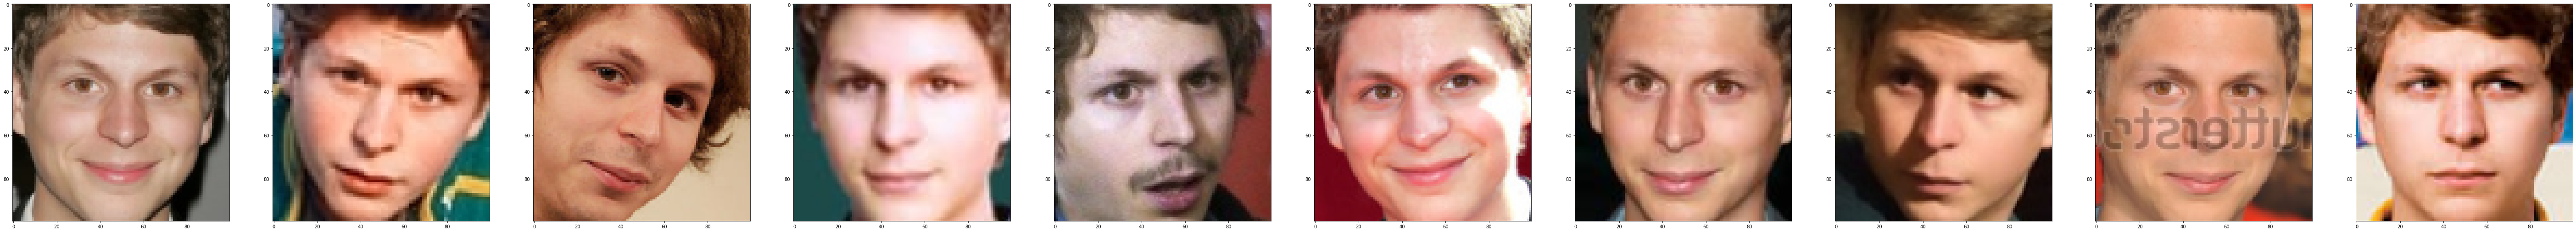

In [22]:
plot_image_sequence(train_X_mirror, n=10, imgs_per_row=10)

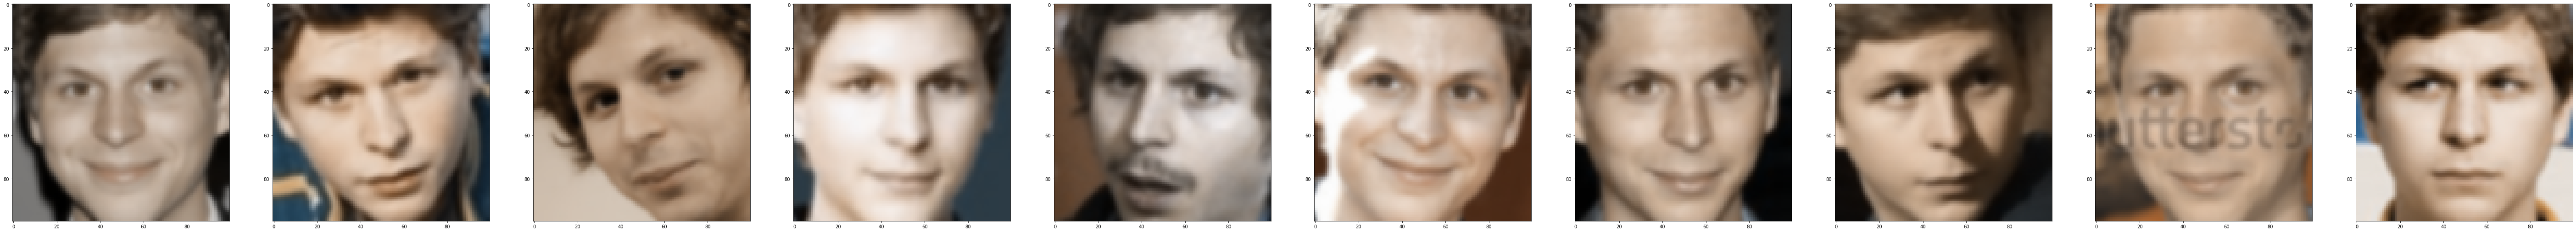

In [23]:
plot_image_sequence(train_X_blurred, n=10, imgs_per_row=10)

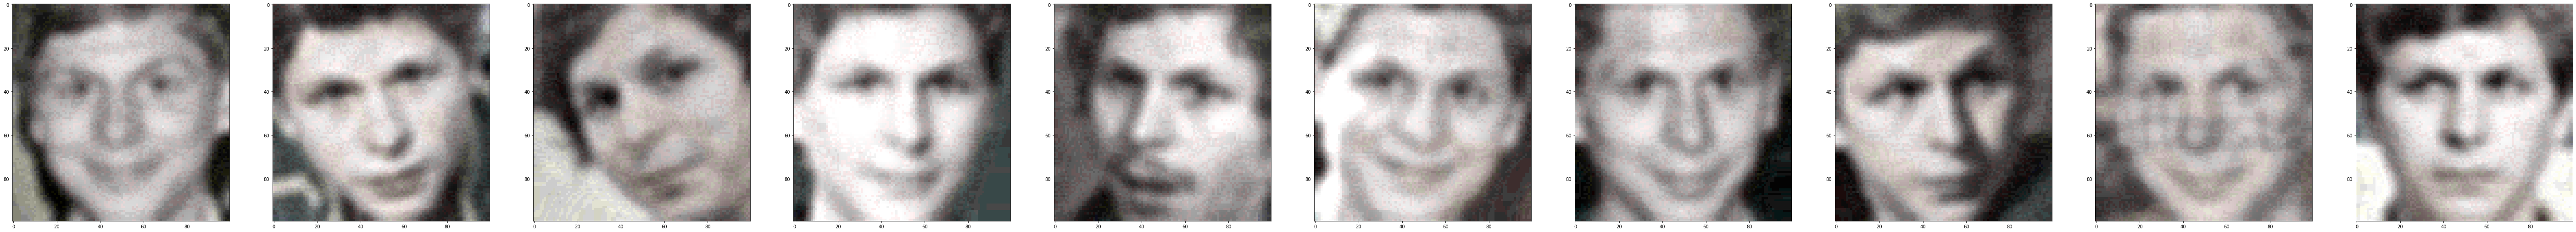

In [24]:
plot_image_sequence(train_X_sharpen, n=10, imgs_per_row=10)

**Warning:**
The above cell is not part of the final code since it did not provide any better results.

Now we are ready to rock!

# 1. Feature Representations

## 1.1 HOG feature extractor

The HOG descriptor is suitable for classification tasks.
At the same time, our data do not contain a high level of distortion, such as scale and rotation, where SIFT is a more suitable choice. 
Therefore, the best descriptor choice for our classification task, when choosing between HOG and SIFT, is the HOG descriptor.

An easy-to-grasp, straightforward way to extract HOG features of each image in the training set and visualize the resulting HOG image is the scikit-image Histogram of Oriented Gradients.  
Default & optional arguments:  
```skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None, *, channel_axis=None)```

When extracting the feature descriptor vectors, your aim is to find the perfect balance between the length of the vectors and the level of feature detail that the vector describes. 
Therefore, you increase/reduce the size of the cells to which the image will be split into, as well as the size of the block that moves across the image.
A good strategy to follow when selecting the parameter values is a trial and error approach until you get a satisfactory level of detail in the visualisation of the feature descriptor vectors.

Parameters/agruments of the HOG feature descriptor:
* **orientations** : Number of orientation bins
* **pixels_per_cell** : (optional) 2-tuple (int, int), Size (in pixels) of a cell  
Example of choosing 16 pixels per cell (crude feature representation) in a 100 x 100 px image and gradually reducing the cell size down to 2 pixels per cell (detailed feature representation)

![mila](https://media2.giphy.com/media/rf91vyDTfLe7LZ2PPN/giphy.gif)

* **cells_per_block** :(optional) 2-tuple (int, int), Number of cells in each block.  
* **block_norm** : Block normalization method:  
"L1" : Normalization using L1-norm.  
"L1-sqrt" : Normalization using L1-norm, followed by square root.  
"L2" : Normalization using L2-norm.      
* **visualize** : If set to True, the method HOGFeatureExtractor.transform() also returns an image of the HOG. For each cell and orientation bin, this image contains a line segment that is centered at the cell center, is perpendicular to the midpoint of the range of angles spanned by the orientation bin, and has intensity proportional to the corresponding histogram value.
* **feature_vector** : (bool, optional) When TRUE: return the data as a feature vector (1D, flattened array is returned)  

The skimage.feature.hog method returns:
* **out** : ndarray of the HOG descriptor for the image. If `feature_vector` is True, a 1D
        (flattened) array is returned.
* **hog_image** : (M, N) ndarray, optional
        A visualisation of the HOG image. Only provided if `visualize` argument is True.

More information about Histogram of Oriented Gradients can be found in the following links:  
*    [Histogram of Oriented Gradients explained using OpenCV](https://learnopencv.com/histogram-of-oriented-gradients/)
*    [Scikit-image HOG (explanation & code)](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)
*    [Scikit-image HOG Github documentation](https://github.com/scikit-image/scikit-image/blob/main/skimage/feature/_hog.py)
*    [Scikit-image HOG Scikit Image documentation](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog)
    

/opt/conda/lib/python3.7/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


Train HOG Image shapes are  (76, 100, 100)
Train HOG features matrix shape is  (76, 1152)
Test HOG Image shapes are  (1816, 100, 100)
Test HOG features matrix shape is  (1816, 1152)


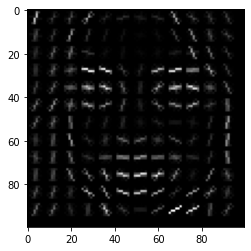

In [25]:
from skimage.feature import hog

def hog_extraction(data):
    # Feature extraction with HOG
    hog_images = []
    hog_features = []

    for i in range(len(data)):
        temp_hog_feature, temp_hog_image = hog(data[i], orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize = True, multichannel = True, block_norm='L2')
        hog_images.append(temp_hog_image)
        hog_features.append(temp_hog_feature)

    hog_images = np.array(hog_images)
    hog_features = np.array(hog_features)
    return hog_features, hog_images


train_X_hog_features, train_X_hog_images = hog_extraction(train_X)
test_X_hog_features, test_X_hog_images = hog_extraction(test_X)

# Printing a sample hog feature image
print("Train HOG Image shapes are ", train_X_hog_images.shape)
print("Train HOG features matrix shape is ", train_X_hog_features.shape)
print("Test HOG Image shapes are ", test_X_hog_images.shape)
print("Test HOG features matrix shape is ", test_X_hog_features.shape)
plt.imshow(train_X_hog_images[12], cmap='gray')
plt.show()

**Important points:**

Local features refer to a pattern or distinct structure found in an image, such as a point, edge, or small image patch. They are usually associated with an image patch that differs from its immediate surroundings by texture, color, or intensity. What the feature actually represents does not matter. What matters is that it is distinct from its surroundings. Examples of local features are blobs, corners, and edge pixels. 

Local features let you find image correspondences regardless of occlusion, changes in viewing conditions, or the presence of clutter. In addition, the properties of local features make them suitable for image classification.

We use local features to represent image contents compactly for classification, without requiring image segmentation.

Feature extraction involves computing a descriptor, which is typically done on regions centered around detected features. 
Descriptors rely on image processing to transform a local pixel neighborhood into a compact vector representation. 
This new representation permits comparison between neighborhoods regardless of changes in scale or orientation. 

One way to make your descriptor behave well in different circumstances (e.g. image with different lighting) is normalization. Normalization (the fourth stage in the HOG descriptor calculation) takes local groups of cells and normalises their overall responses before passing to next stage. **Normalisation introduces better invariance to illumination, shadowing, and edge contrast**. It is performed by accumulating a measure of local histogram “energy” over local groups of cells (blocks). The result is used to normalise each cell in the block. Typically each individual cell is shared between several blocks, but its normalisations are block dependent and thus different. The cell thus appears several times in the final output vector with different normalisations. This may seem redundant but it improves the performance.   

**Note**:  
A feature representation can be:  
**robust** = same features are extracted from the same object in different conditions  
**discriminative** = different image objects can be easily separated from each other in feature space) 

### 1.1.1. t-SNE Plots

T-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.  
T-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.
TSNE is a heuristic therefore it is a good idea to define a random state based on a constant seed in order to keep track of the changes applied when tuning the rest of the parameters, because the initial state will be stable.
BEWARE: Like most heuristics, it might behave quite differently according to small changes.  
Some of the parameters involved in the T-SNE Plotting are:
* **n_components=2** : Dimension of the embedded space
* **verbose=1** : Level of explanations during execution time 
* **perplexity=25** : The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger     perplexity. range between 5 and 50. Different values can result in significantly different results.
* **random_state=1** : Determines the random number generator. An integer leads to reproducible results across multiple function calls.Different initializations might result in different local minima of the cost function.
* **n_iter=1000** : Maximum number of iterations for the optimization. Should be at least 250.
* **learning_rate=30** : The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum, increasing the learning rate may help. 


More information about TSNE can be found in the following links: 

* [TSNE Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
* [PYTHON example](https://www.youtube.com/watch?v=85XaciPBCkw)
* [Theoretical explanation](https://www.youtube.com/watch?v=NEaUSP4YerM)
* [Why You Are Using t-SNE Wrong And how to avoid the common pitfalls (with code!)](https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0)
    

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


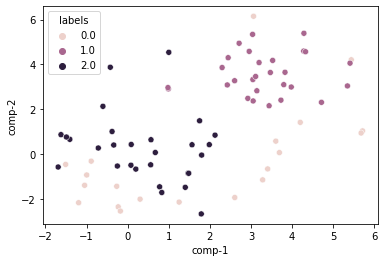

In [26]:
# Convert the feature descriptors' list into a pandas dataframe
# rows: vectors, columns: dimensions
df_descriptors = pd.DataFrame(train_X_hog_features)

# Fitting t-SNE and ploting the high-dimensional datapoints in 2D
m = TSNE(learning_rate=100, random_state = 17)
tsne_features = m.fit_transform(df_descriptors)
df_descriptors['labels'] = train_y
df_descriptors['comp-1'] = tsne_features[:,0]
df_descriptors['comp-2'] = tsne_features[:,1]
sns.scatterplot(x="comp-1", y="comp-2", marker='o', hue= df_descriptors['labels'], data = df_descriptors)
plt.show()


## 1.2 PCA feature extractor

In order to apply principal component analysis (PCA), singular value decomposition (SVD) is required. SVD can be mathematically written as

$$
A = U \Sigma V^T
$$

where 
* A is a data matrix , 
* U is the orthogonal vector representing rotation input space, 
* Σ is a matrix with singular values on the diagonal and 
* V is the orthonormal matrix defining input space (principal directions).

If eigenvalue decomposition is used, the input has to be a squared matrix. In case the data matrix is rectangular, a squared matrix can be obtained by using the covariance matrix. 

In order to perform SVD, the input has to be a 2D matrix. 

Since we need to stack a number of 2D colored images, we need to preprocess the input data the following way: 

* **Grayscale conversion: the images are converted to grayscale to get rid of the color channels**
* **Centering: the input matrix has to be centered. This way, the first principal component corresponds to the component having the maximum variance. Ιt is applied by computing the mean face image and subtracting it from the other images**
* **Normalization: the images have to be normalized. It is applied by dividing each image by 255**
* **Flattening: each 2D image is converted to a 1D vector by flattening out the corresponding matrix**

A singular value in terms of PCA represents a magnitude of variability. We can choose how many components are necessary in order to represent our image in our lower dimensional space based on the variance of the input data. The first principal component is corresponding to the direction in space where projections have a maximum variance i.e. most significant feature. The second principal component corresponds to the direction with second largest variance and so on. In order to know how much components/values are necessary to represent the image, the cumulative percentage of variance is plotted. A cumulative percentage of 95% is chosen which corresponds to ... components. The total number of non-zero singular values obtained by the SVD is equal to the number of input images because this is the value of the lowest dimension of the input data matrix.
    
More information about Principal Component Analysis (PCA) can be found in the following links:
* [A Step-by-Step Explanation of Principal Component Analysis (PCA)](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) 
* [Face Recognition using Principal Component Analysis](https://machinelearningmastery.com/face-recognition-using-principal-component-analysis/) 
* [Sklearn PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
* [Github PCA documentation](https://github.com/scikit-learn/scikit-learn/blob/37ac6788c/sklearn/decomposition/_pca.py#L116)
* [EigenFaces and A Simple Face Detector with PCA/SVD in Python](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)

In [27]:
# Converts all the images of the given dataset into grayscale
# (number of images, 100, 100, 3) -> (number of images, 100, 100)
def grayscale_conversion(images):
    grayscale_images = []
    for img in images:
        img_float32 = np.float32(img)
        # Convert image into grayscale
        gray_image = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(gray_image)
    return np.array(grayscale_images)

In [28]:
# Finds the mean image of the given dataset
def find_mean_image(images):
    mean_image = np.mean(images, axis = 0)
    # Convert the data type of the image (float ---> int8)
    mean_image_converted = mean_image.astype(np.uint8)
    return mean_image_converted

In [29]:
# Subtracts the mean image from every image in the given dataset
def mean_subtraction(images, average_image):
    # PCA requires centered points
    # For this reason we can subtract the mean image from every 
    # image in the dataset
    without_mean = []
    for img in images:
        without_mean.append(img - average_image)
    return np.array(without_mean)

In [30]:
# Normalizes all the images in the given dataset
def image_normalization(images):
    normalized_images = []
    for img in images:
        normalized_images.append(np.true_divide(img, 255))

    return np.array(normalized_images)

In [31]:
# Flattens all the images in the given dataset
# (number of images, h, w) -> (number of images, h*w)
def image_flattening(images):
    flattened_images = []
    for img in images:
        flattened_image = img.flatten()
        flattened_images.append(flattened_image)
    return np.array(flattened_images)

The mean face of the training set:


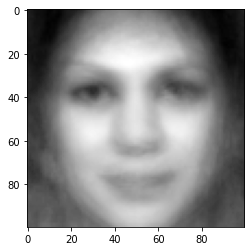

In [32]:
print("The mean face of the training set:")
plt.figure
plt.imshow(find_mean_image(grayscale_conversion(train_X)), cmap = "gray")
plt.show()


In [33]:
# Plots the 2D matrices corresponding to the given number of principal component
def plot_components(pca_obj, number_components, width, height, n_rows):
    n_cols = number_components//n_rows + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize = (20,20),
                           gridspec_kw = dict(hspace = 0.01, wspace = 0.01),
                           sharex=True, sharey= True)

    for i, ax in enumerate(axes.flat):
        try:
            comp = pca_obj.components_[i]
            ax.annotate(f"Comp: {i+1}", (35, 10), backgroundcolor = 'white', size = 10)
            ax.imshow(comp.reshape(width, height), cmap = 'gray')
        except:
            img = np.multiply(np.ones([width, height]), 255).astype(np.uint8)
            ax.imshow(img, cmap = 'gray')

    plt.suptitle('PCA Components', backgroundcolor = 'white')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.show()

In [34]:
def PCA_SVD_fit(images, number_components, details = True):
    pca_obj = PCA(number_components)
    pca_obj.fit(images)

    # Find reconstruction error
    comp = pca_obj.transform(images)
    transformed_images = pca_obj.inverse_transform(comp)
    error = np.linalg.norm((images - transformed_images), None)

    if details:
        print('Explained variance per principal component:\n {}' .format(pca_obj.explained_variance_ratio_))
        print('Total explained variance: {}' .format(np.sum(pca_obj.explained_variance_ratio_)))
        print('Reconstruction Error: {}' .format(error))

    return pca_obj, np.sum(pca_obj.explained_variance_ratio_), error

In [35]:
# PCA Preprocessing of training data

# Converts images to grayscale
grayscaled_train = grayscale_conversion(train_X)

# Finds the average image of the given images
average_image_train = find_mean_image(grayscaled_train)

# Subtracts mean image from images
images_without_mean_train = mean_subtraction(grayscaled_train, average_image_train)

# Images normalization
images_normalized_train = image_normalization(images_without_mean_train)

# Flatten Images
# PCA requires a 2D matrix as input
images_flattened_train = image_flattening(images_normalized_train)

In [36]:
# PCA Preprocessing of testing data

# Converts images to grayscale
grayscaled_test = grayscale_conversion(test_X)

# Finds the average image of the given images
average_image_test = find_mean_image(grayscaled_test)

# Subtracts mean image from images
images_without_mean_test = mean_subtraction(grayscaled_test, average_image_test)

# Images normalization
images_normalized_test = image_normalization(images_without_mean_test)

# Flatten Images
# PCA requires a 2D matrix as input
images_flattened_test = image_flattening(images_normalized_test)

### 1.2.1 Eigenface Plots

The following plot represents the eigenvector or eigenfaces in decreasing order of significance. The first eigenface (F1) corresponds to the first principal component. The eigenfaces are extracted from the V matrix, in formula of SVD. If a face is still recognizable in the eigenface, the eigenface is useful as component. If the eigenface contains more noise, the components are not that useful anymore.

The following images will be reconstructed using gradually more eigenfaces: 

Raw image: 



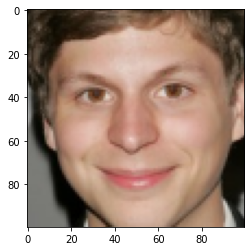



After subtracting the mean face from the raw image: 



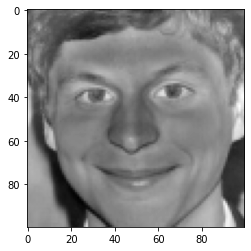

-------------------------------------------------------------------------------------------------------------------------


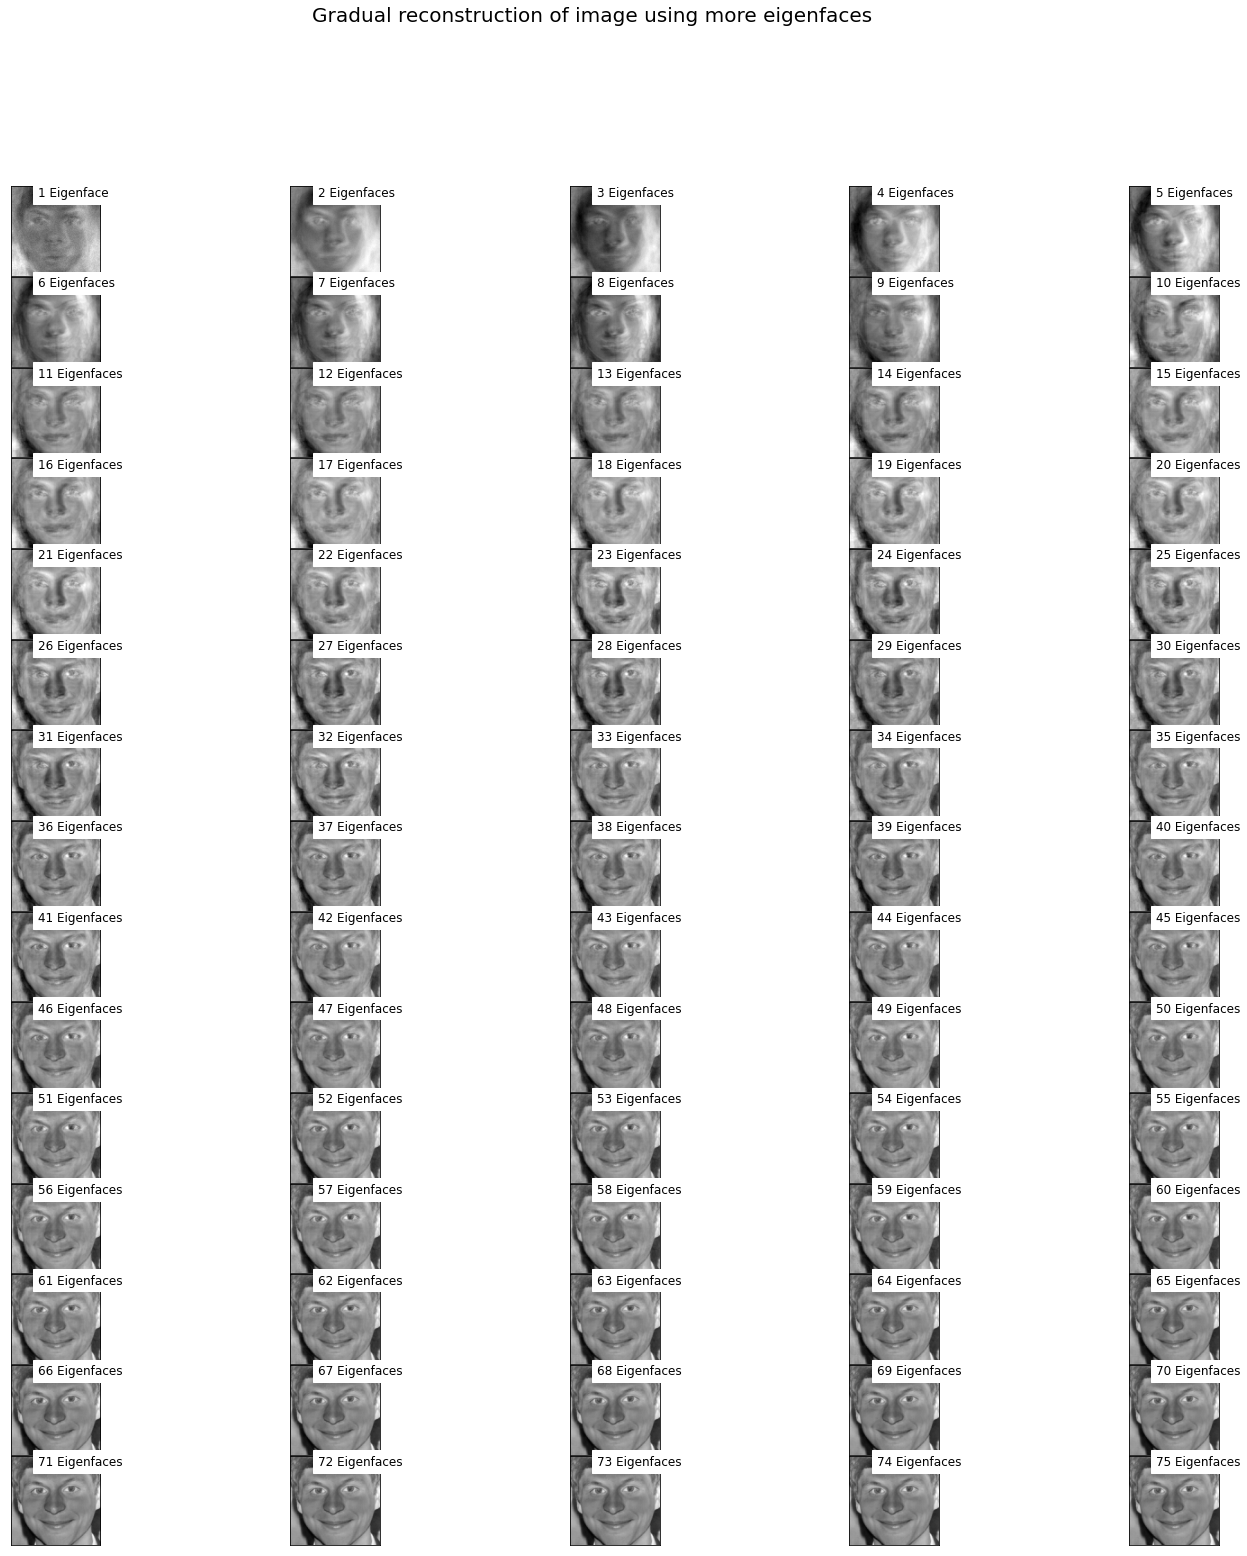

In [37]:
# Face reconstuction using gradually more eigenfaces
print('The following images will be reconstructed using gradually more eigenfaces: \n')

# Taking the first image of our dataset as a sample image to perform PCA incrementally 
image_to_reconstruct = train_X[0]
image_to_reconstruct_without_mean = images_without_mean_train[0]

print('Raw image: \n')
plt.imshow(image_to_reconstruct, cmap = 'gray') 
plt.show()

print('\n\nAfter subtracting the mean face from the raw image: \n')
plt.imshow(image_to_reconstruct_without_mean, cmap = 'gray')
plt.show()


print('-------------------------------------------------------------------------------------------------------------------------')

# Create a list to store the results of the incremental approach (adding more components)
gradually_reconstructed = []
reconstruction_error = []
for n_components in range(1, 77):
    # Fit PCA in training set
    pca_tmp, variance, error = PCA_SVD_fit(images_flattened_train, number_components = n_components, details = False)
    # Transform the training set
    comp_tmp = pca_tmp.transform(images_flattened_train)
    # Perform inverse transformation to take the reconstructed images
    tmp_projected = pca_tmp.inverse_transform(comp_tmp)
    # Add the reconstructed image choosen for the study (first in training set)
    gradually_reconstructed.append(tmp_projected[0].reshape(100, 100))
    # Calculate the recostruction error
    total_loss = np.linalg.norm((image_to_reconstruct_without_mean/255 - tmp_projected[0].reshape(100, 100)), None)
    reconstruction_error.append(total_loss)

    
# Plot the results of the inverse transformation
fig, axes = plt.subplots(15, 5, figsize = (25,25),
                         gridspec_kw = dict(hspace = 0.01, wspace = 0.01),
                         sharex=True, sharey= True)
  
for i, ax in enumerate(axes.flat):
    img = gradually_reconstructed[i]
    try:    
        if i == 0:
            ax.annotate(f"{i+1} Eigenface", (30, 10), backgroundcolor = 'white', size = 12)
            ax.imshow(img.reshape(100, 100), cmap = 'gray')
        else:
            ax.annotate(f"{i+1} Eigenfaces", (30, 10), backgroundcolor = 'white', size = 12)
            ax.imshow(img.reshape(100, 100), cmap = 'gray')
    except:
        img = np.multiply(np.ones([100, 100]), 255).astype(np.uint8)
        ax.imshow(img, cmap = 'gray')

plt.suptitle('Gradual reconstruction of image using more eigenfaces', backgroundcolor = 'white', fontsize = 20)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

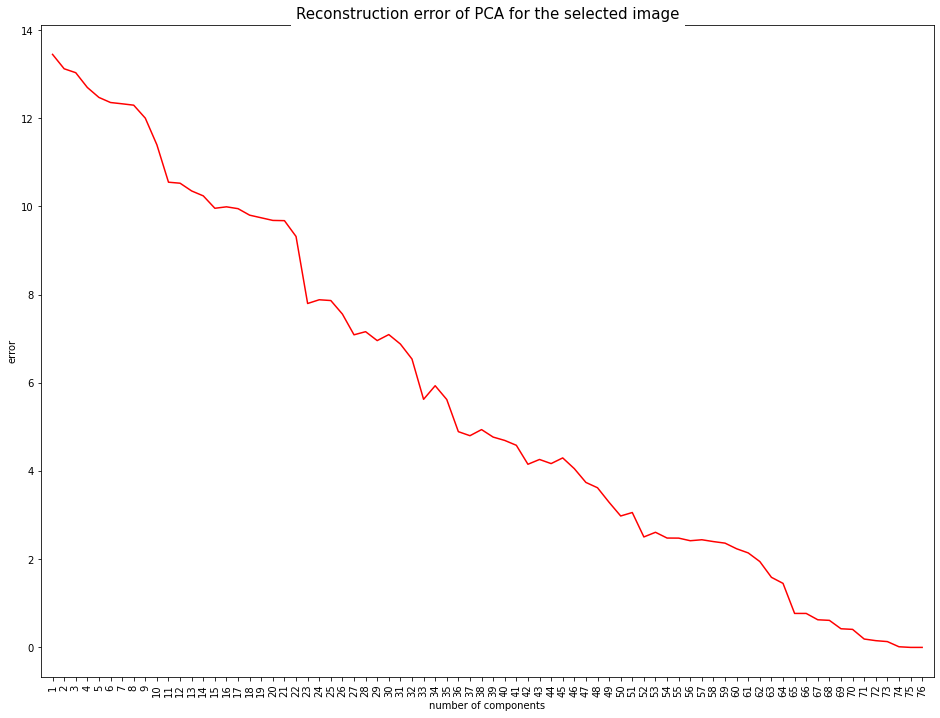

In [38]:
# Plot the recostruction error for the selected image
plt.figure(figsize=(16, 12))
plt.title("Reconstruction error of PCA for the selected image", backgroundcolor = 'white', size = 15)
plt.plot(reconstruction_error, 'r')
plt.xticks(range(len(reconstruction_error)), range(1, 77), rotation='vertical')
plt.xlim([-1, len(reconstruction_error)])
plt.ylabel('error', backgroundcolor = 'white', size = 10)
plt.xlabel('number of components', backgroundcolor = 'white', size = 10)
plt.show()

In [39]:
# Try different number of components in order to find an optimal number.
# You want to reduce the dimensionality (as less features as possible) and 
# retain as much information as possible (explained variance).
explained_variance_list  = []
error_list = []
for n in range(1, 77):
    #print('Number of components: {}' .format(n))
    pca_obj, variance, error = PCA_SVD_fit(images_flattened_train, n, details = False)
    explained_variance_list.append(variance)
    error_list.append(error)
    #print('--------------------------------------------------------------------')
    #print('--------------------------------------------------------------------')

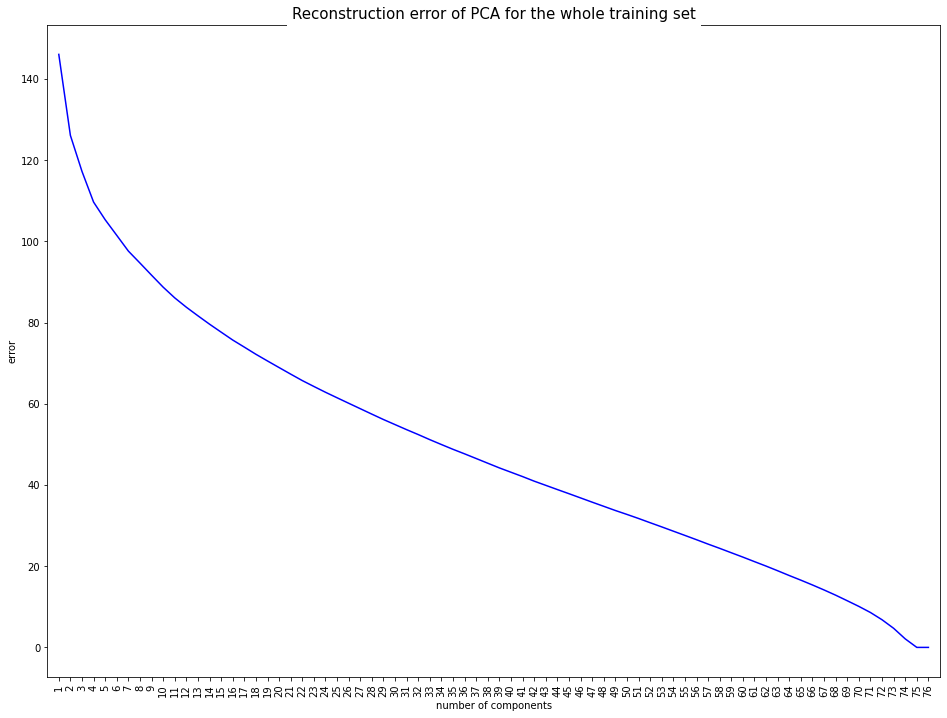

In [40]:
# Plot the recostruction error for all the images
plt.figure(figsize=(16, 12))
plt.title("Reconstruction error of PCA for the whole training set", backgroundcolor = 'white', size = 15)
plt.plot(error_list, 'b')
plt.xticks(range(len(error_list)), range(1, 77), rotation='vertical')
plt.xlim([-1, len(error_list)])
plt.ylabel('error', backgroundcolor = 'white', size = 10)
plt.xlabel('number of components', backgroundcolor = 'white', size = 10)
plt.show()

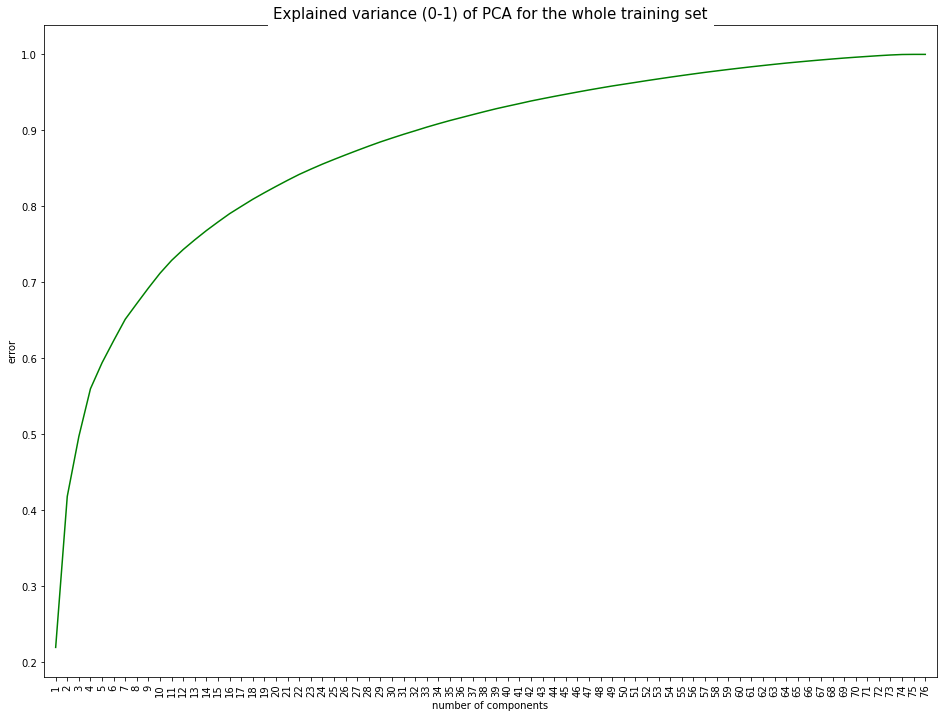

In [41]:
# Plot the explained variance 
plt.figure(figsize=(16, 12))
plt.title("Explained variance (0-1) of PCA for the whole training set", backgroundcolor = 'white', size = 15)
plt.plot(explained_variance_list, 'g')
plt.xticks(range(len(explained_variance_list)), range(1, 77), rotation='vertical')
plt.xlim([-1, len(explained_variance_list)])
plt.ylabel('error', backgroundcolor = 'white', size = 10)
plt.xlabel('number of components', backgroundcolor = 'white', size = 10)
plt.show()

Explained variance per principal component:
 [2.1976034e-01 1.9863191e-01 7.8894489e-02 6.2743694e-02 3.4184281e-02
 2.9112043e-02 2.8178254e-02 2.0720221e-02 2.0401539e-02 1.9449301e-02
 1.6893119e-02 1.4286938e-02 1.2804480e-02 1.2213937e-02 1.1264650e-02
 1.0914242e-02 9.5484536e-03 9.4321994e-03 8.6665666e-03 8.2629547e-03
 8.1861839e-03 7.5985771e-03 6.9760834e-03 6.5959473e-03 6.1498829e-03
 6.0424455e-03 5.8489460e-03 5.7387082e-03 5.4140314e-03 5.0744470e-03
 4.9464749e-03 4.8495107e-03 4.6898220e-03 4.3561771e-03 4.2480403e-03
 4.0670205e-03 3.8968492e-03 3.8905353e-03 3.7431307e-03 3.5087757e-03
 3.3613294e-03 3.2981294e-03 3.0583288e-03 2.9481570e-03 2.9007038e-03
 2.8102733e-03 2.7451764e-03 2.6705496e-03 2.5527354e-03 2.4336036e-03
 2.3413706e-03 2.3284557e-03 2.2771577e-03 2.2234048e-03 2.1189889e-03
 2.1166932e-03 2.0334083e-03 1.9039051e-03 1.8707240e-03 1.7605615e-03
 1.7426440e-03 1.6509068e-03 1.6350247e-03 1.5753683e-03 1.4274811e-03
 1.3827231e-03 1.3270795e-03 1.2

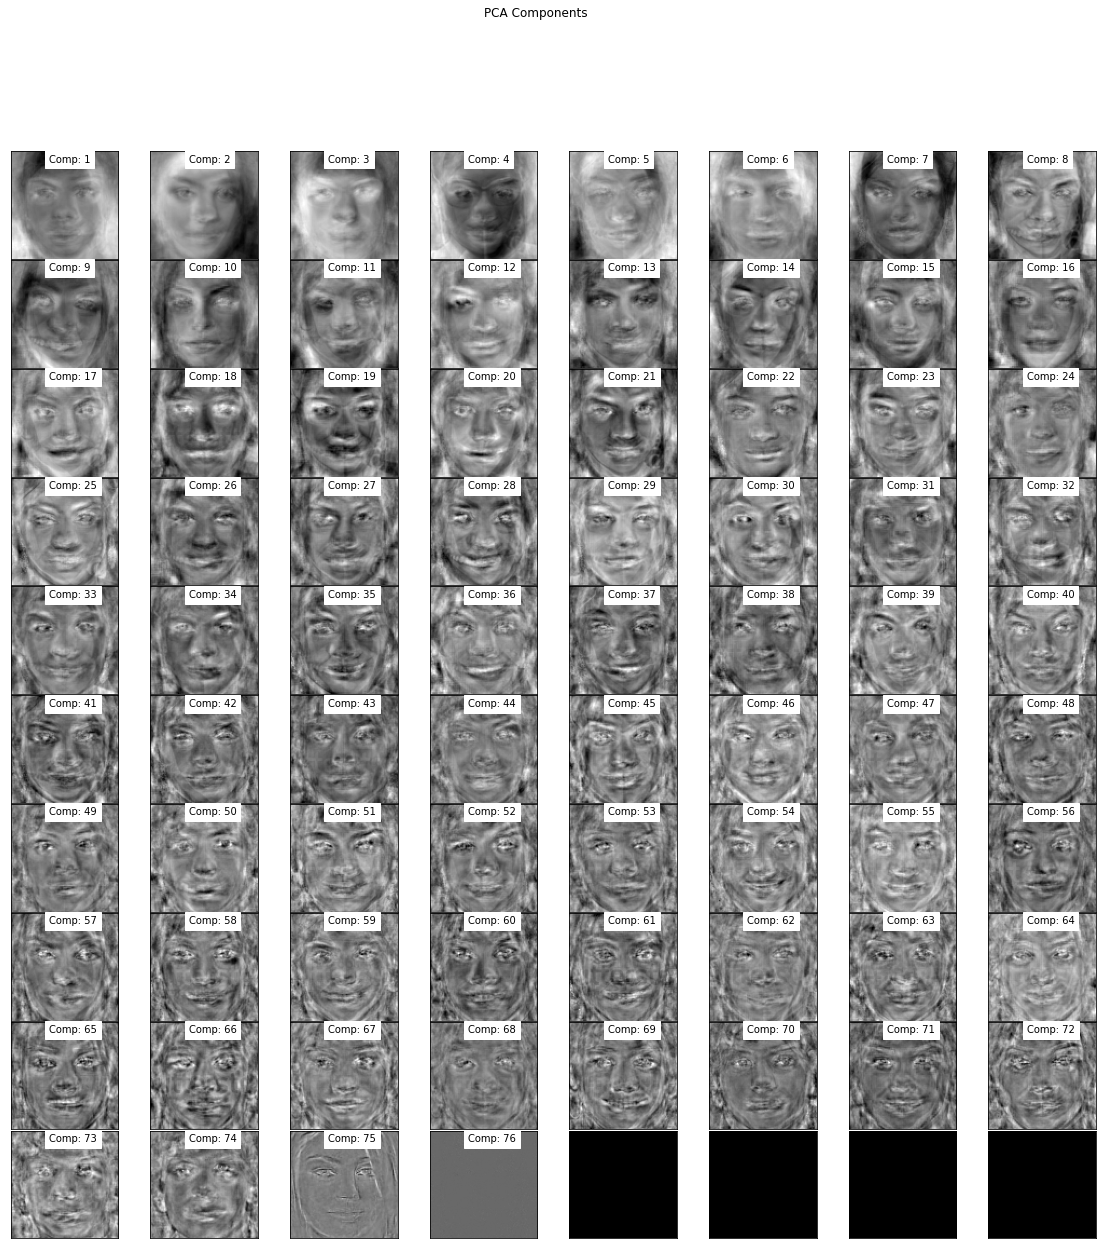

In [42]:
# Optimal number of compenents: 35 
# Explained variance: 99.09%
# Reconstruction Error: 12.06
# PCA fitting 
pca_obj, variance, error = PCA_SVD_fit(images_flattened_train, 76)

print('-----------------------------------------------------------------------')
print('-----------------------------------------------------------------------')
print('\n')

# Plot the components
plot_components(pca_obj, number_components = 76, width = 100, height = 100, n_rows = 10)

# Apply PCA in training set
components_train = pca_obj.transform(images_flattened_train)
# Apply PCA in test set
# components_test = pca_obj.transform(images_flattened_test)

In [43]:
# Choosing the best number of principal components in order to have 99 % reconstruction accuracy
print("Optimal number of principal components in order to have 99 % reconstruction accuracy: ", np.where(pca_obj.explained_variance_ratio_.cumsum() > 0.99)[0][0])

pca_final, variance, error = PCA_SVD_fit(images_flattened_train, number_components = 65, details = False)
comp = pca_final.transform(images_flattened_train)
projected = pca_final.inverse_transform(comp)

pca_features_train_X = projected


pca_final, variance, error = PCA_SVD_fit(images_flattened_test, number_components = 65, details = False)
comp = pca_final.transform(images_flattened_test)
projected = pca_final.inverse_transform(comp)

pca_features_test_X = projected


Optimal number of principal components in order to have 99 % reconstruction accuracy:  65


In order to reconstruct an image, the following formula is applied:

$$F = F_m + \sum_{i=1}^{n}a_iF_i$$

Where F is the reconstructed image, $F_m$ is the average face image, $F_i$ is an eigenvector or eigenface, α is a weight corresponding to the reconstructed image. The more principal components are added, the fewer visible changes in the images occur. This means this components are getting less important for image reconstruction.

Explained variance per principal component:
 [0.21976034 0.19863191 0.07889449 0.06274369 0.03418428 0.02911204
 0.02817825 0.02072022 0.02040154 0.0194493  0.01689312 0.01428694
 0.01280448 0.01221394 0.01126465 0.01091424 0.00954845 0.0094322
 0.00866657 0.00826295 0.00818618 0.00759858 0.00697608 0.00659595
 0.00614988 0.00604245 0.00584895 0.00573871 0.00541403 0.00507445
 0.00494647 0.00484951 0.00468982 0.00435618 0.00424804 0.00406702
 0.00389685 0.00389054 0.00374313 0.00350878 0.00336133 0.00329813
 0.00305833 0.00294816 0.0029007  0.00281027 0.00274518 0.00267055
 0.00255274 0.0024336  0.00234137 0.00232846 0.00227716 0.0022234
 0.00211899 0.00211669 0.00203341 0.00190391 0.00187072 0.00176056
 0.00174264 0.00165091 0.00163502 0.00157537 0.00142748]
Total explained variance: 0.9899702668190002
Reconstruction Error: 16.560476303100586
-----------------------------------------------------------------------
-----------------------------------------------------------------------


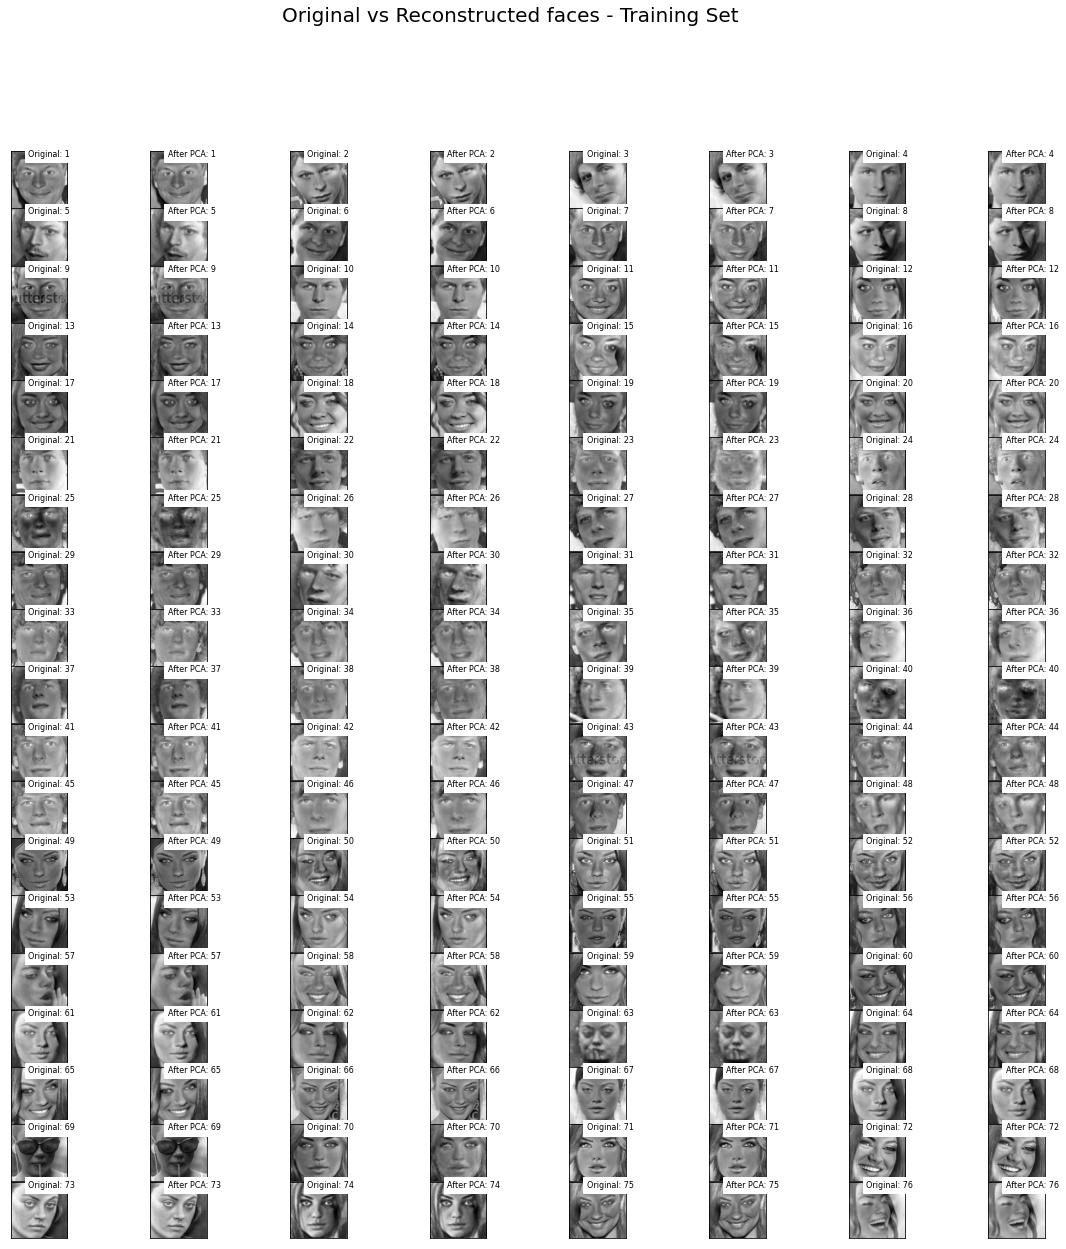

In [44]:
# Apply PCA in training set for the optimal number of components
pca_obj, variance, error = PCA_SVD_fit(images_flattened_train, 65)

print('-----------------------------------------------------------------------')
print('-----------------------------------------------------------------------')
print('\n')


components_train = pca_obj.transform(images_flattened_train)

reconstructed_images_train = pca_obj.inverse_transform(components_train)

fig, axes = plt.subplots(19, 8, figsize = (20,20),
                         gridspec_kw = dict(hspace = 0.01, wspace = 0.01),
                         sharex=True, sharey= True)
  
for i, ax in enumerate(axes.flat):
    j = i//2
    try:
        if i%2 == 0:
            img = images_flattened_train[j]
            ax.annotate(f"Original: {j+1}", (30, 10), backgroundcolor = 'white', size = 8)
            ax.imshow(img.reshape(100, 100), cmap = 'gray')
        else:
            img = reconstructed_images_train[j]
            ax.annotate(f"After PCA: {j+1}", (30, 10), backgroundcolor = 'white', size = 8)
            ax.imshow(img.reshape(100, 100), cmap = 'gray')
    except:
        img = np.multiply(np.ones([100, 100]), 255).astype(np.uint8)
        ax.imshow(img, cmap = 'gray')

plt.suptitle('Original vs Reconstructed faces - Training Set', backgroundcolor = 'white', fontsize = 20)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

### 1.2.2 Feature Space Plots

The feature space is plotted using the first two components. As seen in the second features space plot, there is some correlation with images from the same class. However, using only 2 principal components is not enough to distinguish different classes.

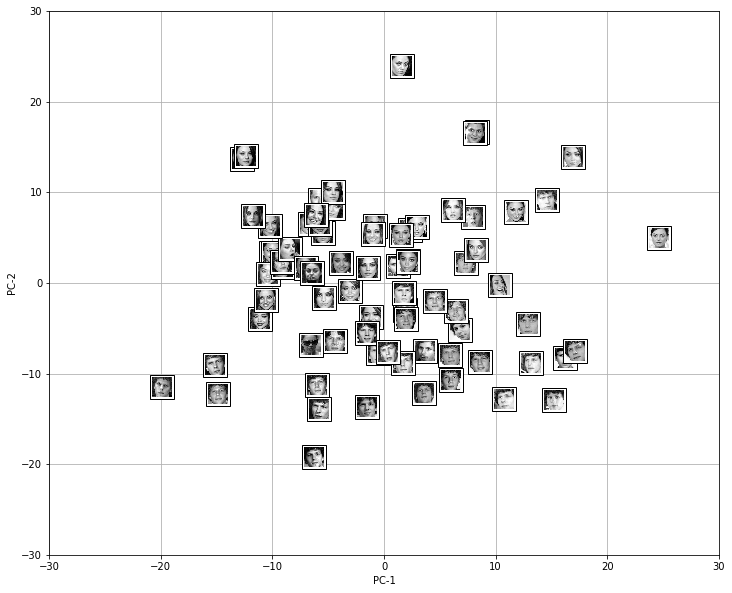

In [45]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

# find the corresponding vectors using pca
n_components = 2
pca = PCA(n_components)
projected = pca.fit_transform(images_flattened_train)

# define labels
labels = train_y

# define corresponding eigenvectors
points = projected

# definition: plotting images
def imscatter(points, images, ax):
    for (x, y), image in zip(points, images):
        im = OffsetImage(image.T, zoom=1, cmap = "gray")
        ab = AnnotationBbox(im, (x, y), frameon=True, pad=0.2)
        ax.add_artist(ab)

# define images         
images = np.zeros((76, 1, 20, 20))
for i in range(76):
    image = train_X[i]
    img_float32 = np.float32(image)
    gray_image = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)
    new_image = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    new_image = cv2.resize(new_image, (0, 0), fx=0.2, fy=0.2)
    images[i] = np.transpose(new_image)

# plot feature space
fig, ax = plt.subplots(figsize = (12,10))


ax.set_ylim([-30, 30])
ax.set_xlim([-30, 30])

imscatter(points, images, ax)
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.grid()
plt.show() 

In order to better distinguish the distribution of the three classes according to the first two principal components, an extra scatter plot is displayed to indicate the different classes with different colors.

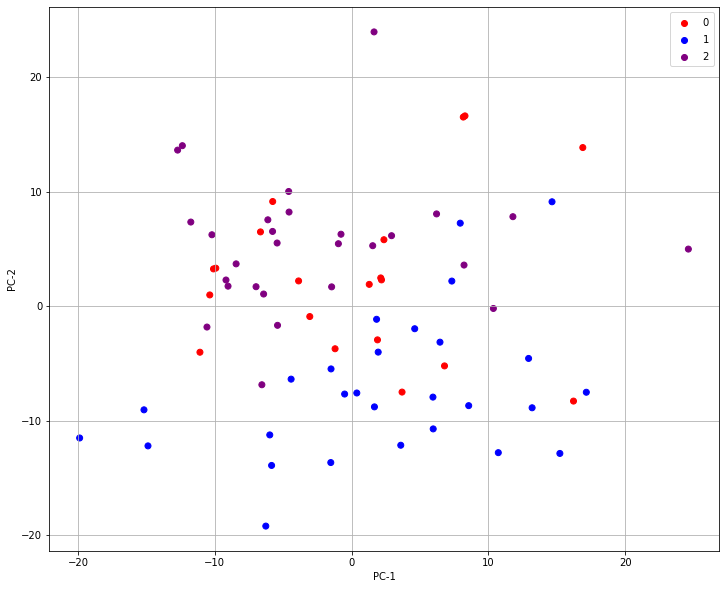

In [46]:
#import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

n_components = 2
pca = PCA(n_components)
projected = pca.fit_transform(images_flattened_train)

labels = train_y

fig, ax = plt.subplots(figsize = (12,10))

colors = ListedColormap(['red', 'blue', 'purple'])

scatter = plt.scatter(projected[:, 0], projected[:, 1], c=labels, cmap=colors)

plt.legend(*scatter.legend_elements())


plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.grid()
plt.show()

## 1.3 Transfer Learning
### 1.3.1 VGG Face

In order to increase generalization performance (test prediction accuracy) we utilized Transfer Learning of a pre-trained CNN VGG16 model. The model has been trained on 2.6M annotated images.

We utilize the pretrained VGG 16 convolutional neural network model by fine-tuning its parameters with Stochastic Gradient Descent (SGD) and specifically with the Adam optimizer of the tensorflow library, configured for Sparse Categorical Cross Entropy loss for multilabel classification task.


The model final fully connected layer was truncated to 3 neurons to account for the 3 image classes of our dataset. Freezing of the pre-trained VGG16 model final layer parameters (Average Pooling) and dropout regularization were further implemented to reduce overfitting to the validation dataset.

In order to mitigate the non-convexity of the image classification task, a small learning rate (lr = 0.005) was chosen, as well as gradient clipping. 


<div align=center height="20" width="20" style="margin-top:20px; margin-bottom:20px">
    <img src="https://drive.google.com/uc?export=view&id=19vuV0q6SKHCcO6jKP4ym8xJMVTHoOTh0">
    <figcaption>Figure 1: Transfer Learning on VGG16 diagram. Freezing network weights and biases renders them unmodifiable by the Adam optimizer during fine-tuning: Results in better validation performance since general training image features captured by the pre-trained model are not lost during transfer learning.</figcaption>
</div>

More information can be found in [Deep Face Recognition](http://www.bmva.org/bmvc/2015/papers/paper041/paper041.pdf)

In [47]:
import tensorflow as tf

In [48]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 254 kB/s            


In [49]:
# Required packages to run the VGG Face Model
# !pip install git+https://github.com/rcmalli/keras-vggface.git
# !pip install keras_applications


**Important Note:**
The following cells were required in order to run the jupyter notebook on kaggle. Normally installing the two packages indicated on the above cell are enough to install and run everything. However, in the case of kaggle, we faced an error that couldn't be solved manually and required access to directories and files that we did not have. As a result, we had to copy the parts of two .py files from keras-vggface package.

In [50]:
'''VGGFace models for Keras.

# Notes:
- Utility functions are modified versions of Keras functions [Keras](https://keras.io)

'''

import numpy as np
from keras import backend as K
from keras.utils.data_utils import get_file

V1_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v1.npy'
V2_LABELS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy'

VGG16_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_vgg16.h5'
VGG16_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'


RESNET50_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_resnet50.h5'
RESNET50_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_resnet50.h5'

SENET50_WEIGHTS_PATH = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_senet50.h5'
SENET50_WEIGHTS_PATH_NO_TOP = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_senet50.h5'


VGGFACE_DIR = 'models/vggface'


def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp


def decode_predictions(preds, top=5):
    LABELS = None
    if len(preds.shape) == 2:
        if preds.shape[1] == 2622:
            fpath = get_file('rcmalli_vggface_labels_v1.npy',
                             V1_LABELS_PATH,
                             cache_subdir=VGGFACE_DIR)
            LABELS = np.load(fpath)
        elif preds.shape[1] == 8631:
            fpath = get_file('rcmalli_vggface_labels_v2.npy',
                             V2_LABELS_PATH,
                             cache_subdir=VGGFACE_DIR)
            LABELS = np.load(fpath)
        else:
            raise ValueError('`decode_predictions` expects '
                             'a batch of predictions '
                             '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                             '(samples, 8631) for V2.'
                             'Found array with shape: ' + str(preds.shape))
    else:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 2622)) for V1 or '
                         '(samples, 8631) for V2.'
                         'Found array with shape: ' + str(preds.shape))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [[str(LABELS[i].encode('utf8')), pred[i]] for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results


In [51]:
from tensorflow.python.keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
#from tensorflow.python.keras._impl.keras.applications.imagenet_utils import _obtain_input_shape
#from tensorflow.python.keras._impl.keras.utils import layer_utils
#from tensorflow.python.keras._impl.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
import tensorflow
import keras
#from keras_vggface import utils
#from tensorflow.python.keras._impl.keras.engine.topology import get_source_inputs
import warnings
from tensorflow.python.keras.models import Model
from keras_applications.imagenet_utils import _obtain_input_shape
#from tensorflow.python.keras import layers

def VGG16(include_top=True, weights='vggface',
          input_tensor=None, input_shape=None,
          pooling=None,
          classes=2622):
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, name='fc6')(x)
        x = Activation('relu', name='fc6/relu')(x)
        x = Dense(4096, name='fc7')(x)
        x = Activation('relu', name='fc7/relu')(x)
        x = Dense(classes, name='fc8')(x)
        x = Activation('softmax', name='fc8/softmax')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

            # Ensure that the model takes into account
            # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        # Create model.
    model = Model(inputs, x, name='vggface_vgg16')  # load weights
    if weights == 'vggface':
        if include_top:
            weights_path = keras.utils.data_utils.get_file('rcmalli_vggface_tf_vgg16.h5',
                                    VGG16_WEIGHTS_PATH,
                                    cache_subdir=VGGFACE_DIR)
        else:
            weights_path = keras.utils.data_utils.get_file('rcmalli_vggface_tf_notop_vgg16.h5',
                                    VGG16_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir=VGGFACE_DIR)
        model.load_weights(weights_path, by_name=True)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='pool5')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc6')
                layer_utils.convert_dense_weights_data_format(dense, shape,
                                                              'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [52]:
# Checking GPU devices for tensorflow

'''
if tf.test.gpu_device_name(): 
    print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
'''

'\nif tf.test.gpu_device_name(): \n    print(\'Default GPU Device:  {}\'.format(tf.test.gpu_device_name()))\nelse:\n    print("Please install GPU version of TF")\n'

In [53]:
vgg_features = VGG16(include_top = False,
                       weights = 'vggface',
                       input_shape = (100, 100, 3),
                       pooling = 'avg')

2022-04-12 20:47:21.515394: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58925056/58909280 [==============================] - 3s 0us/step


In [54]:
print(vgg_features.summary())

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 100, 100, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 100, 100, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 50, 50, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 25, 128)     

In [55]:
# Using pre-trained model VGGFace for feature extraction
def vgg_feature_extractor(images):
    vgg_features = VGG16(include_top = False,
                       weights = 'vggface',
                       input_shape = (100, 100, 3),
                       pooling = 'avg')
    vgg_features_list = []
    for img in images:
        # Normalize the image
        normalized_img = img/255
        # Add one more dimension. 
        # The input image of the model should have the following structure:
        # (Instances of the batch, Height, Width, number of channels), example: (1, 100, 100, 3)
        normalized_img_ready = np.expand_dims(normalized_img, axis = 0)
        pred = vgg_features.predict(normalized_img_ready)
        vgg_features_list.append(pred[0])

    vgg_features_arr = np.array(vgg_features_list)
    return vgg_features_arr


In [56]:
vgg_features_train_X = vgg_feature_extractor(train_X)
vgg_features_test_X = vgg_feature_extractor(test_X)

2022-04-12 20:47:29.451849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# 2. Evaluation Metrics

In order to evaluate the quality of our classification we can use the following metrics:
* **Accuracy** is the proportion of correct predictions (both true positives and true negatives) among the total number of results examined.
* **F1-Score** is calculated from the precision and the recall of the classifier, where the precision is the number of true positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of true positive results divided by the number of all samples that should have been identified as positive.
* **Precision** is the ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a biometric system is at predicting the positive class. Precision is referred to as the positive predictive value.
* **Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.
* **Confusion matrix** $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$. Thus in binary classification, the count of true negatives $C_{0,0}$ is, false negatives is $C_{1,0}$ , true positives is $C_{1,1}$ and false positives is $C_{0,1}$ .


Additional Material:
* [Accuracy score (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

* [F1_score (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

* [Precision_score (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

* [Recall_score (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

* [Confusion Matrix calculation (sklearn)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

* [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

In [57]:
import sklearn
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


def eval_metrics(actual_labels, predicted_labels, names):
# [np.array] actual_labels : Ground truth (correct) labels
# [np.array] predicted_labels: Predicted labels, as returned by a classifier
# [list] names : Names corresponding to each class

    Accuracy = sklearn.metrics.accuracy_score(actual_labels,predicted_labels)
    print("Accuracy: ",Accuracy)

    F1_score = sklearn.metrics.f1_score(actual_labels,predicted_labels,average='micro')
    print("F1 score: ",F1_score)

    Precision_score = precision_score(actual_labels,predicted_labels,average='micro')
    print("Precision Score : ",Precision_score)

    Recall_Score = recall_score(actual_labels,predicted_labels, average='micro')
    print("Recall Score : ",Recall_Score)

    # Compute confusion matrix to evaluate the accuracy of the classification
    Confusion_Matrix = confusion_matrix(actual_labels,predicted_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=Confusion_Matrix,display_labels = names)
    disp.plot()
    plt.show()



# 3 Classifiers
## 3.1 Random Forest Classifier
The random forest classifier is an ensemble of multiple decision trees. The general idea is to build a large number of individual decision trees, each of which will yield a prediction. The prevailing prediction is the final outcome of the model.

<div align=center style="margin-top:20px; margin-bottom:20px">
    <img src="https://drive.google.com/uc?export=view&id=1DpNTTEnsaq2MimO87QjfshUsAswebwTQ" style="align-items:center">
    <figcaption>Figure 2: Visualization of a Random Forest Model. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes the model’s prediction</figcaption>
</div>

The most important precondition for a good random forest classifier is to have <strong>uncorrelated</strong> decision trees, i.e. ensure that the various decision trees are not too similar. This is accomplished with two methods:

#### Method 1: Bagging or Bootstrap Aggregation

In this method each individual decision tree takes random samples (with replacement) from the training dataset. Therefore, each individual decision tree is created with different samples from the training dataset. 

<div align=center style="margin-top:20px; margin-bottom:20px">
    <img src="https://drive.google.com/uc?export=view&id=1qAShkDRkQRg9APj7LIyz8WH3Fm_0sn8n">
</div>

#### Method 2: Feature Randomness

In this method each individual decision tree selects a random subset of the total features of the training dataset to be trained on.

<div align=center style="margin-top:20px; margin-bottom:20px">
    <img src="https://drive.google.com/uc?export=view&id=10G3goNMBw4mf9Q42aoboj2Zu7iFkXIHh">
</div>

These two methods create various, uncorrelated trees that have been trained on different subsets of the dataset and use different features to make decisions.

More information about the Random Forest classifier can be found <a href="https://towardsdatascience.com/understanding-random-forest-58381e0602d2">here</a>.


In [58]:
''' Building the Random Forest classifier'''
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier as RF

def classifier_RandomForest(train_sbset, train_classes, valid_sbset, valid_classes, n_estimators):
    '''
        This function fits a Random Forest classifier to the given training subset.
    '''
    # Step 1: Training the classifier (clf)
    ###  n_estimators: The number of trees in the forest. (default=100)
    ###  bootstrap:    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. (default=True)
    ###  random_state: Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
    clf = RF(n_estimators, random_state = 17) # random_state = 17 simply sets seed to the random generator, so that the train-test splits are always deterministic. If you don't set seed, it is different each time.
    clf.fit(train_sbset, train_classes)

    # Take the predictions of the model
    train_predictions = clf.predict(train_sbset)     # Should be very similar to the training_labels
    valid_predictions = clf.predict(valid_sbset)

    # Calculate the accuracy
    train_acc = accuracy_score(train_classes, train_predictions) # Should be close to 1. If we have high accuracy in the training dataset and low accuracy in the test dataset it means our model is overfitting.
    valid_acc = accuracy_score(valid_classes, valid_predictions) # The more the merrier

    print("RF Training set accuracy: {:.2f}%" .format(100*train_acc))
    print("RF Validation set accuracy: {:.2f}%" .format(100*valid_acc))     
    
    return clf, train_predictions, valid_predictions

## 3.2 Support Vector Machines (SVM) Classifier

<strong>SVM</strong> is a supervised machine learning algorithm that helps in classification or regression problems. It aims to find an optimal boundary between the possible outputs, by maximizing the separation boundaries between the data points, depending on the defined labels or classes.

SVM were built to support <strong>binary classification</strong> and separating data points into two classes. The algorithm can be adjusted to handle multiclass classification, by breaking down the multiclassification problem into multiple binary classification problems. This can be accomplished with various techniques, one of which is the <strong>One-vs-One scheme</strong>.

In the One-vs-One strategy, the multiclassification problem is divided into one binary classification problem per each pair of classes.

The <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">built-in SVM function of scikit-learn package</a> is used below, which uses the One-vs-One scheme to support multiple classes.

More information about Support Vector Machines can be found in the following links:
<ul>
    <li><a href="https://www.baeldung.com/cs/ml-support-vector-machines">Support Vector Machines (SVM)</a></li>
    <li><a href="https://www.baeldung.com/cs/svm-multiclass-classification">Multiclass Classification Using Support Vector Machines</a></li>
    <li><a href="https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/">One-vs-Rest and One-vs-One for Multi-Class Classification</a></li>
</ul>

In [59]:
#Import SVM model
from sklearn import svm
from sklearn import metrics

def classifier_SVM(train_sbset, train_classes, valid_sbset, valid_classes, kernel_type='linear'):

    # Create the SVM classifier
    clf = svm.SVC(kernel = kernel_type)

    # Fit the SVM classifier to the given training subset.
    clf.fit(train_sbset, train_classes)

    # Use the SVM classifier to predict the class of the training and the validation subset
    train_predictions = clf.predict(train_sbset)
    valid_predictions = clf.predict(valid_sbset)
    
    # Calculate the accuracy
    train_acc = accuracy_score(train_classes, train_predictions) # Should be close to 1. If we have high accuracy in the training dataset and low accuracy in the test dataset it means our model is overfitting.
    valid_acc = accuracy_score(valid_classes, valid_predictions) # The more the merrier

    print("SVM Training set accuracy: {:.2f}%" .format(100*train_acc))
    print("SVM Vadidation set accuracy: {:.2f}%" .format(100*valid_acc))
 
    return clf, train_predictions, valid_predictions

### Splitting the dataset to training and validation subsets

In order to check the model's performance, a validation dataset is needed to compare the model's predictions against actual labels.

One way is to simply split the training dataset into training and validation subsets, using a fixed analogy, such as 80% training-20% validation for example. This approach is also known as <strong>hold-out</strong>.

Another way to split the dataset is the <strong>k-fold cross-validation</strong> technique, in which the dataset is split randomly into k groups. Then, the model is trained and evaluated k times using in each itteration a different group as the validation set, while the remaining groups are used for training.

A comparison of these two techniques can be found <a href="https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f">here</a>.

In [60]:
from sklearn.model_selection import train_test_split

def hold_out_splitter(compl_data, compl_classes, valid_percentage=0.2, random_state=17):
    '''
    This function splits the complete classified dataset into a training and a validation subset.
    
        Parameters:
                    ~ compl_data:       The complete, classified dataset that is available.
                    ~ compl_classes:    The corresponding classes of the given dataset.
                    ~ valid_percentage: The percentage of the complete, classified dataset that will be used to create the validation subset.
                    ~ random_state:     Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. 
        Return:
                    ~ train_sbset:      The training subset that will be used to train the model.
                    ~ valid_sbset:      The validation subset that will be used to evaluate the model's performance.
                    ~ train_classes:    The classes of the training subset.
                    ~ valid_classes:    The classes of the validation subset.
    '''
    train_sbset, valid_sbset, train_classes, valid_classes = train_test_split(compl_data, compl_classes, stratify=compl_classes, test_size = valid_percentage, random_state = random_state)

    return train_sbset, valid_sbset, train_classes, valid_classes

In [61]:
from sklearn.model_selection import StratifiedKFold

def k_fold_evaluator(compl_data, compl_classes, k=10):

    skf = StratifiedKFold(n_splits=k)
    
    rf_mean_train_acc = 0
    rf_mean_valid_acc = 0
    svm_mean_train_acc = 0
    svm_mean_valid_acc = 0
    
    for train_index, test_index in skf.split(compl_data, compl_classes):
        # Split the dataset
        train_sbset, valid_sbset = compl_data[train_index], compl_data[test_index]
        train_classes, valid_classes = compl_classes[train_index], compl_classes[test_index]
        
        # Calculate the accuracy of the Random Forest classifier for this fold
        rf_clf, rf_train_pred, rf_valid_pred = classifier_RandomForest(train_sbset, train_classes, valid_sbset, valid_classes, n_estimators=100)
        rf_mean_train_acc += accuracy_score(train_classes, rf_train_pred)
        rf_mean_valid_acc += accuracy_score(valid_classes, rf_valid_pred)
        
        # Calculate the accuracy of the SVM classifier for this fold
        svm_clf, svm_train_pred, svm_valid_pred = classifier_SVM(train_sbset, train_classes, valid_sbset, valid_classes, kernel_type='linear')
        svm_mean_train_acc += accuracy_score(train_classes, svm_train_pred)
        svm_mean_valid_acc += accuracy_score(valid_classes, svm_valid_pred)
        
        print("----------------------------------------------------------------------------------------\n")
        
    rf_mean_train_acc = rf_mean_train_acc/k
    rf_mean_valid_acc = rf_mean_valid_acc/k
    svm_mean_train_acc = svm_mean_train_acc/k
    svm_mean_valid_acc = svm_mean_valid_acc/k
    
    print("The mean accuracy for the RF classifier in the training subset is ", rf_mean_train_acc)
    print("The mean accuracy for the RF classifier in the validation subset is ", rf_mean_valid_acc)
    print("The mean accuracy for the SVM classifier in the training subset is ", svm_mean_train_acc)
    print("The mean accuracy for the SVM classifier in the validation subset is ", svm_mean_valid_acc)
    

Calling the respective functions:

In [62]:
# Altering the training classes by adding an extra class -1 to distinguish Michael from Sarah
# in order to have equal distribution of the two look alikes in the training set
train_y = np.concatenate((np.ones(10)*(-1), np.ones(10)*(0), np.ones(28), np.ones(28)*2), axis=0)

In [63]:
# Calling the hold_out_splitter function to split the dataset in a stratified manner
train_sbset, valid_sbset, train_classes, valid_classes = hold_out_splitter(pca_features_train_X, train_y, 0.2, 17)

In [64]:
# Changing back to 3 classes (0, 1, 2) 
train_classes[train_classes == -1] = 0
valid_classes[valid_classes == -1] = 0

In [65]:
# Calling the k-fold evaluation function
k_fold_evaluator(pca_features_train_X, train_y, k=10)

RF Training set accuracy: 100.00%
RF Validation set accuracy: 75.00%
SVM Training set accuracy: 100.00%
SVM Vadidation set accuracy: 100.00%
----------------------------------------------------------------------------------------

RF Training set accuracy: 100.00%
RF Validation set accuracy: 62.50%
SVM Training set accuracy: 100.00%
SVM Vadidation set accuracy: 75.00%
----------------------------------------------------------------------------------------

RF Training set accuracy: 100.00%
RF Validation set accuracy: 87.50%
SVM Training set accuracy: 100.00%
SVM Vadidation set accuracy: 75.00%
----------------------------------------------------------------------------------------

RF Training set accuracy: 100.00%
RF Validation set accuracy: 62.50%
SVM Training set accuracy: 100.00%
SVM Vadidation set accuracy: 75.00%
----------------------------------------------------------------------------------------

RF Training set accuracy: 100.00%
RF Validation set accuracy: 87.50%
SVM Traini

In [66]:
# Using the random forest as a classifier
rf_clf, rf_train_pred, rf_valid_pred = classifier_RandomForest(train_sbset, train_classes, valid_sbset, valid_classes, 100)

RF Training set accuracy: 100.00%
RF Validation set accuracy: 75.00%


In [67]:
# Using the SVM as a classifier
svm_clf, svm_train_pred, svm_valid_pred = classifier_SVM(train_sbset, train_classes, valid_sbset, valid_classes, kernel_type='linear')

SVM Training set accuracy: 100.00%
SVM Vadidation set accuracy: 87.50%


Accuracy:  0.75
F1 score:  0.75
Precision Score :  0.75
Recall Score :  0.75


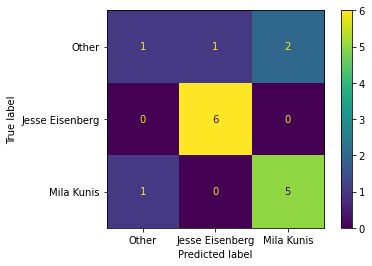

In [68]:
eval_metrics(valid_classes, rf_valid_pred, names = ["Other", "Jesse Eisenberg", "Mila Kunis"])

Accuracy:  0.875
F1 score:  0.875
Precision Score :  0.875
Recall Score :  0.875


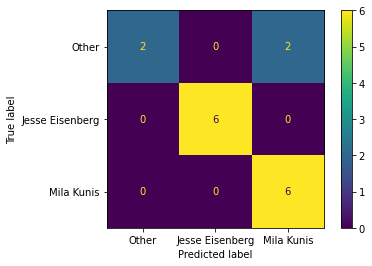

In [69]:
eval_metrics(valid_classes, svm_valid_pred, names = ["Other", "Jesse Eisenberg", "Mila Kunis"])

# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Best pipeline

A typical machine learning pipeline would consist of the following processes:
<div>
    <ul>
        <li>Data collection/extraction</li>
        <li>Data cleaning</li>
        <li>Feature extraction (labelling and dimensionality reduction)</li>
        <li>Model training</li>
        <li>Model validation/evaluation</li>
        <li>Visualisation</li>
    </ul>
</div>

Given the methods that we implemented, namely, HOG feature extractor, PCA feature extractor and VGG Face model, and using the following classifiers, Random Forest and Support Vector Machines (SVM), we found out that the best results are given by the following combination: VGG features given as an input in a SVM.

In [70]:
# Example Pipeline

# Loading preprocessed images
prep_path = '../input/prepped-data'
if not os.path.exists(prep_path):
    os.mkdir(prep_path)
train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
test_X = np.load(os.path.join(prep_path, 'test_X.npy'))


michael = []
sarah = []
for i in range(len(train_X[train_y == 0])):
    if (i==0 or i==1 or i==3 or i==4 or i==6 or i==9 or i==11 or i==17 or i==18 or i==19):
        michael.append(train_X[train_y == 0][i])
    else:
        sarah.append(train_X[train_y == 0][i])
michael = np.array(michael)
sarah = np.array(sarah)
jesse = train_X[train_y == 1]
mila = train_X[train_y == 2]


train_X = np.concatenate((michael, sarah, jesse, mila), axis=0)
train_y = np.concatenate((np.ones(20)*(0), np.ones(28), np.ones(28)*2), axis=0)



# Image Feature Extraction
# The choice between: hog_extractor, pca_feature_extractor and vgg_feature_extractor
# is made here
vgg_features_train_X = vgg_feature_extractor(train_X)
vgg_features_test_X = vgg_feature_extractor(test_X)

SVM Training set accuracy: 98.33%
SVM Vadidation set accuracy: 100.00%
Accuracy:  1.0
F1 score:  1.0
Precision Score :  1.0
Recall Score :  1.0


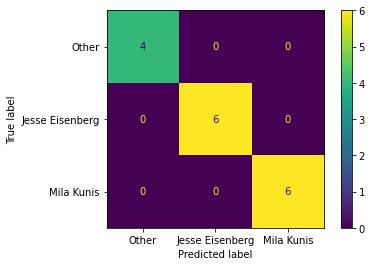

In [71]:
''' Train/Validation Split '''

# Altering the training classes by adding an extra class -1 to distinguish Michael from Sarah
# in order to have equal distribution of the two look alikes in the training set
train_y = np.concatenate((np.ones(10)*(-1), np.ones(10)*(0), np.ones(28), np.ones(28)*2), axis=0)

# Calling the hold_out_splitter function to split the dataset in a stratified manner
train_sbset, valid_sbset, train_classes, valid_classes = hold_out_splitter(vgg_features_train_X, train_y, 0.2, 17)

# Changing back to 3 classes (0, 1, 2)
train_classes[train_classes == -1] = 0
valid_classes[valid_classes == -1] = 0

# Training the classifier on the train/validation sets
# The choice between: svm_classifier and random forest classifier
# is made here
svm_clf, svm_train_pred, svm_valid_pred = classifier_SVM(train_sbset, train_classes, valid_sbset, valid_classes, kernel_type='linear')

# Evaluating the classifier's predictions on the validation set 
# Calculating Accuracy, F1 score, Precision, Recall and displaying the Confusion Matrix
eval_metrics(valid_classes, svm_valid_pred, names = ['Other','Jesse Eisenberg','Mila Kunis'])

# Predicting the labels of the testing set images
# for final submission
test_y_star = svm_clf.predict(vgg_features_test_X)
test_y_star = np.array(test_y_star).astype('int64')

# 5. Publishing best results

In [72]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      1
1812      1
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [73]:
submission.to_csv('submission_vgg_svm.csv')

# 6. Discussion

In summary we contributed the following: 
* We explored three different techniques in for feature extraction, namely, Histogram of Oriented Gradients, Principal Component Analysis and pre-trained Convolutional Neural Network (VGG16).
* We used two different classifiers to perform face recognition based on the extracted features.
* We presented all our resources in the most possible educative way keeping in mind that the readers of this notebook should effortlessly navigate themselves and have access to the material we used.
* We followed a functional programming approach instead of an object oriented one. Our final result was a pipeline containing all the required components/functions for the face recognition task.
